In [1]:
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm.auto import tqdm
import cv2

# from tensorflow.keras.applications import Densnet
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
import tensorflow.keras as keras
from tensorflow.data import Dataset

from tensorflow.keras.optimizers import Adam, RMSprop, Nadam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from itertools import product
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

2022-06-11 11:28:44.425254: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
tf.__version__

'2.4.1'

In [4]:
IMAGE_SIZE = 320
MODEL_IMAGE_SIZE = 224
SECTION_CLASS_NUM = 4
DISEASE_CLASS_NUM = 3
GROW_CLASS_NUM = 5
BATCH_SIZE = 50

# Data Load

In [5]:
df = pd.read_csv('../../../data/strawberry.csv')
df.head()

,image,disease,area,grow
0,/home/lab38/images/딸기_정상/V006_77_0_00_04_01_13...,0,1,5
1,/home/lab38/images/딸기_정상/V006_77_0_00_04_01_13...,0,1,4
2,/home/lab38/images/딸기_정상/V006_77_0_00_04_01_13...,0,1,5
3,/home/lab38/images/딸기_정상/V006_77_0_00_04_01_13...,0,1,4
4,/home/lab38/images/딸기_정상/V006_77_0_00_04_01_13...,0,1,5


In [6]:
shuffled_df = df.sample(frac=1)

In [7]:
# Train : Validation = 0.8 : 0.2 Split
train_len = int(len(df)*0.8)

train_df = shuffled_df[:train_len]
valid_df = shuffled_df[train_len:]

In [8]:
train_gen = ImageDataGenerator(rescale=1./255,
                            rotation_range=20, # 최대 20도까지 회전
                            width_shift_range=0.1, # 최대 x 범위안에서 좌우/상하 이동
                            height_shift_range=0.1,
                            zoom_range=0.2, # 확대 축소 비율,
                            horizontal_flip=True, # 좌우반전
                            vertical_flip=True, # 상하반전
                            fill_mode='nearest')
valid_gen = ImageDataGenerator(rescale= 1. /255.)

In [9]:
train_generator = train_gen.flow_from_dataframe(train_df, 
                                               x_col='image',
                                               y_col=['area', 'disease', 'grow'],
                                               target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                               class_mode='multi_output',
                                               batch_size=BATCH_SIZE)
valid_generator = valid_gen.flow_from_dataframe(valid_df,
                                               x_col='image',
                                               y_col=['area','disease','grow'],
                                               target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                               class_mode='multi_output',
                                               batch_size=BATCH_SIZE)

Found 17192 validated image filenames.
Found 4298 validated image filenames.


# Label Encoding

# Model
image-label 쌍 3개 input

In [10]:
tf.keras.backend.clear_session()

In [11]:
base_model= resnet50.ResNet50(
          weights='imagenet',
          include_top=False,
         )


base_model.trainable = False 

2022-06-11 11:28:59.042522: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-11 11:28:59.043628: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-06-11 11:28:59.100917: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-11 11:28:59.101513: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-06-11 11:28:59.101556: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-06-11 11:28:59.106842: I tensorflow/stream_executor/platform/default/dso_loade

In [18]:
section_inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name='section_inputs')
disease_inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name='disease_inputs')
grow_inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name='grow_inputs')

inputs = layers.concatenate([section_inputs, disease_inputs, grow_inputs])
inputs = layers.Conv2D(3, (3, 3), activation="relu", padding='same')(inputs)
input_model = Model(inputs=[section_inputs, disease_inputs, grow_inputs],
              outputs=inputs)

In [12]:
input_data = layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3))
x = tf.keras.layers.experimental.preprocessing.Resizing(MODEL_IMAGE_SIZE, MODEL_IMAGE_SIZE)(input_data)
resizing = Model(inputs=input_data, outputs=x, name='resize')

In [20]:
x = resizing(input_model.output)
x = base_model(x, training=False)
x = layers.Conv2D(3, (3,3))(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
backbone_out = layers.Dense(1024, activation='relu')(x)

In [21]:
section_outputs = layers.Dense(SECTION_CLASS_NUM, activation='softmax',
                        name = 'section_outputs')(backbone_out)
disease_outputs = layers.Dense(DISEASE_CLASS_NUM, activation='softmax',
                        name = 'diease_outputs')(backbone_out)
grow_outputs = layers.Dense(GROW_CLASS_NUM, activation='softmax',
                    name = 'grow_outputs')(backbone_out)

model = Model(inputs=[section_inputs, disease_inputs, grow_inputs], 
              outputs=[section_outputs, disease_outputs, grow_outputs],
              name='strawberry_model')

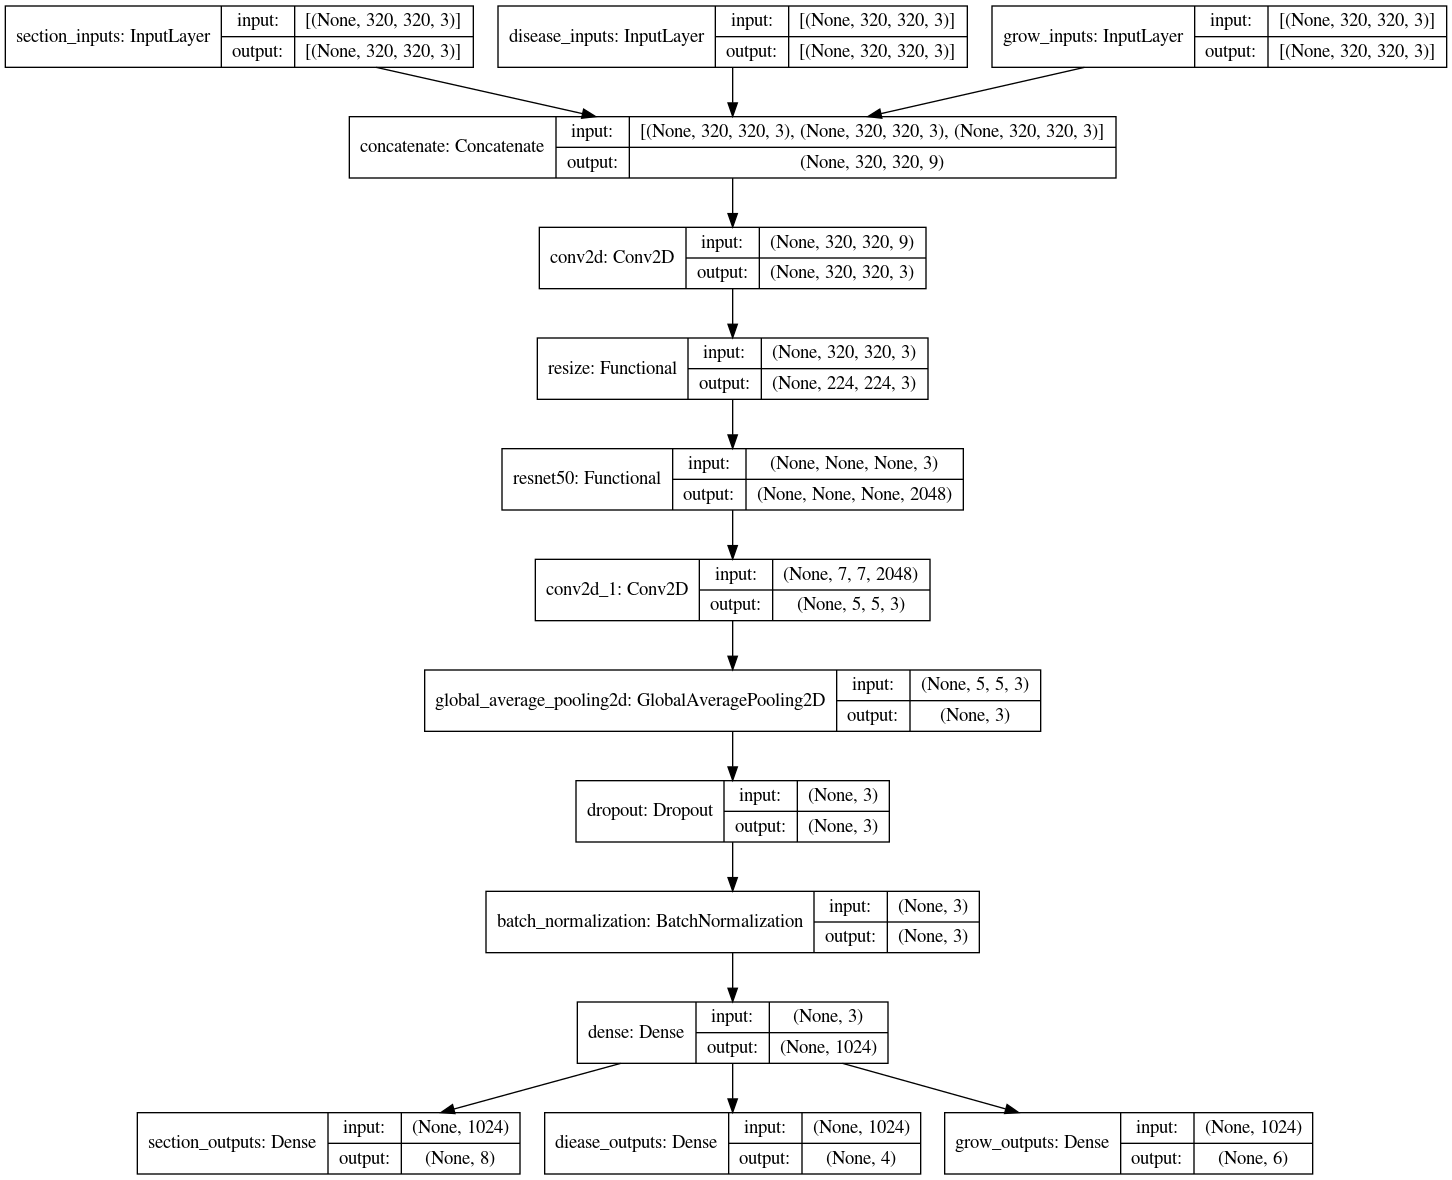

In [22]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()

In [ ]:
model.compile(loss={
                  'section_outputs' : 'sparse_categorical_crossentropy',
                  'diease_outputs' : 'sparse_categorical_crossentropy',
                  'grow_outputs' : 'sparse_categorical_crossentropy'
              },
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy']) # 필요시 f1 score metrics custom

In [ ]:
img.shape

In [ ]:
img = np.array([img])
s = np.array([0])
d = np.array([0])
g = np.array([0])

In [ ]:
model.fit({'section_inputs':img, 'disease_inputs':img, 'grow_inputs':img},
         {'section_outputs': s, 'diease_outputs':d, 'grow_outputs':g},
         epochs=1)

# Other Way
이미지 1개 당 레이블 3개

In [31]:
tf.keras.backend.clear_session()

In [13]:
inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = resizing(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
# x = layers.BatchNormalization()(x)
backbone_out = layers.Dense(1024, activation='softmax')(x)


section_outputs = layers.Dense(SECTION_CLASS_NUM, activation='softmax',
                        name = 'section_outputs')(backbone_out)
disease_outputs = layers.Dense(DISEASE_CLASS_NUM, activation='softmax',
                        name = 'diease_outputs')(backbone_out)
grow_outputs = layers.Dense(GROW_CLASS_NUM, activation='softmax',
                    name = 'grow_outputs')(backbone_out)

model = Model(inputs=inputs, 
              outputs=[section_outputs, disease_outputs, grow_outputs],
              name='strawberry')

In [14]:
model.summary()

Model: "strawberry"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
resize (Functional)             (None, 224, 224, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
resnet50 (Functional)           (None, None, None, 2 23587712    resize[0][0]                     
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 2048)         0           resnet50[0][0]                   
_________________________________________________________________________________________

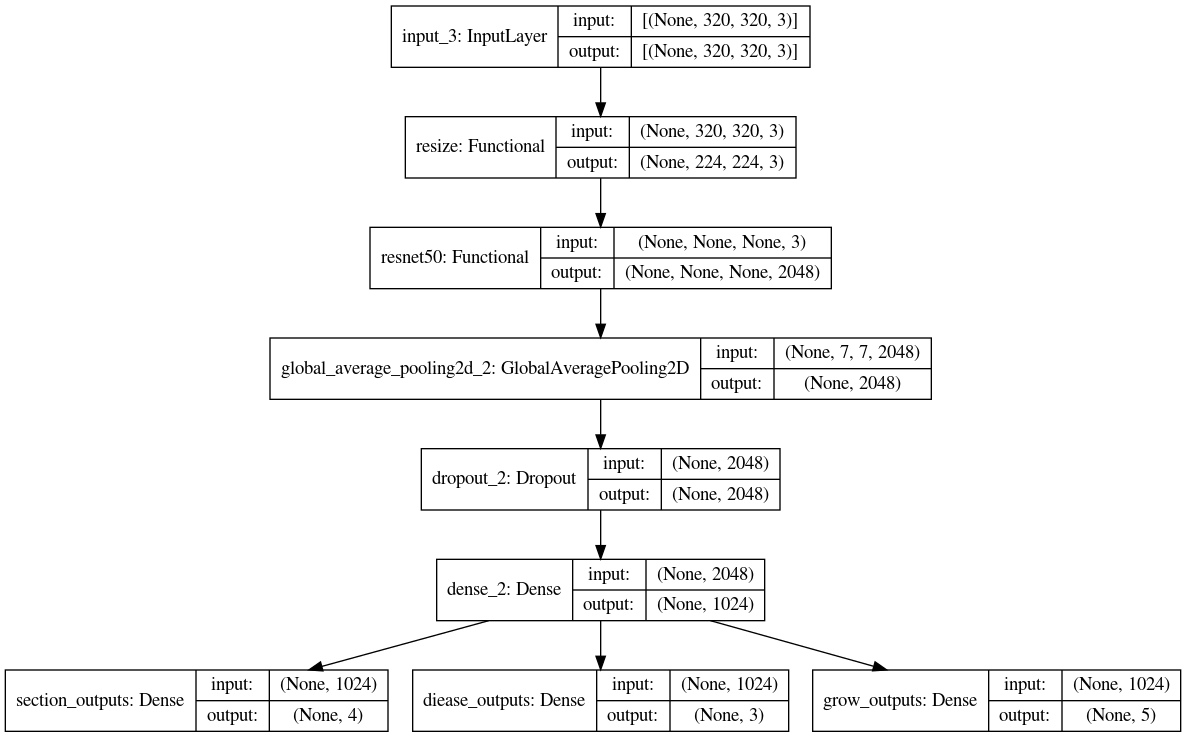

In [43]:
keras.utils.plot_model(model, show_shapes=True)

In [15]:
model.compile(loss={
                  'section_outputs' : 'sparse_categorical_crossentropy',
                  'diease_outputs' : 'sparse_categorical_crossentropy',
                  'grow_outputs' : 'sparse_categorical_crossentropy'
              },
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy']) # 필요시 f1 score metrics custom

In [16]:
model.fit(train_generator,
          validation_data=valid_generator,
          verbose=1,
          epochs=10,
          steps_per_epoch=len(train_df)//BATCH_SIZE)

2022-06-11 11:29:37.574099: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-11 11:29:37.593816: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz


Epoch 1/10


2022-06-11 11:29:40.254991: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-06-11 11:29:48.726669: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


343/343 [==============================] - 3265s 10s/step - loss: nan - section_outputs_loss: nan - diease_outputs_loss: nan - grow_outputs_loss: nan - section_outputs_accuracy: 0.0078 - diease_outputs_accuracy: 0.9033 - grow_outputs_accuracy: 0.0022 - val_loss: nan - val_section_outputs_loss: nan - val_diease_outputs_loss: nan - val_grow_outputs_loss: nan - val_section_outputs_accuracy: 0.0000e+00 - val_diease_outputs_accuracy: 0.9132 - val_grow_outputs_accuracy: 0.0000e+00
Epoch 2/10
343/343 [==============================] - 3221s 9s/step - loss: nan - section_outputs_loss: nan - diease_outputs_loss: nan - grow_outputs_loss: nan - section_outputs_accuracy: 0.0000e+00 - diease_outputs_accuracy: 0.9161 - grow_outputs_accuracy: 0.0000e+00 - val_loss: nan - val_section_outputs_loss: nan - val_diease_outputs_loss: nan - val_grow_outputs_loss: nan - val_section_outputs_accuracy: 0.0000e+00 - val_diease_outputs_accuracy: 0.9132 - val_grow_outputs_accuracy: 0.0000e+00
Epoch 3/10
343/343 [==

KeyboardInterrupt: 

parameter tuning 과정을 보여주기 -> 시각화  
confusion matrix 대각화..? 보여주기  
batch, epoch별로 변화과정..?!!?!  

> mAP, Precision, Recall 점수, Confusion matrix, AUC 커브 등의 자료를 보여주세요.    

> 아직 ResNet50, Faster R-CNN 어느 모델을 사용할지 결정이 되지 않았다면 빨리 결정을 하고 Learning을 하여 위의 지표값을 보고서에 보여주세요.   

> epoch수, batch size, mAP 숫자의 변화 기록 등을 보고서에 넣어주세요.     

> 실제로 스마트폰에서 이미지 촬영 후 object detection되고 그 식물의 성장, 부위, 병충해 여부를 보여조는 모습을 실제 영상으로 보여주세요.  


